In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.font_manager import fontManager, FontProperties
import ptitprince as pt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import pingouin as pg
import statsmodels.api as sm
import language_tool_python as ltp
from PIL import Image


def get_img(name):
    path = "font/emojis/{}.png".format(name)

    if name == 'Human':
        img = plt.imread(path)
    else:
        img = np.asarray(Image.open(path).resize((136, 128)))

    #  im = plt.imread(img)

    return img

def offset_image(coord, name, ax, size=0.5):
    img = get_img(name)
    im = OffsetImage(img, zoom=size)
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -21.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)
    ax.add_artist(ab)

def raincloud(x, y, markersize, df, order=None, hue=None):
    # adding color
    pal = sns.color_palette()
    if df is not None:
        means = df.groupby([x])[y].mean().reindex(order)
    else:
        if len(order) > 2:
            raise Exception('Too many unique x values for this custom plot')

        mean_1 = np.mean([i[0] for i in zip(y, x) if i[1] == order[0]])
        mean_2 = np.mean([i[0] for i in zip(y, x) if i[1] == order[1]])
        means = [mean_1, mean_2]

    dodge = None
    if hue:
        means = df.groupby([x, hue])[y].mean().reindex(order)
        dodge = True
        
    sns.scatterplot(
        x=means.index,
        y=means,
        color='white',
        edgecolor='black',
        s=150/2, linewidth=1.5, zorder=4)

    ax = pt.half_violinplot(x=x, y=y, data=df, palette=pal, bw=.25, cut=0., linewidth=0,
                            scale="area", width=.7, inner=None, orient='v', zorder=1, order=order, hue=hue, dodge=dodge)
    ax = sns.stripplot(x=x, y=y, data=df, palette=pal, edgecolor="white",  linewidth=1, order=order,
                       size=markersize, orient='v', zorder=2, jitter=1, alpha=0.6, hue=hue, dodge=dodge)

    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1,
     edgecolor='black', capsize=.06, zorder=3, bw=0, order=order, hue=hue, dodge=dodge)

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
f1 = 'HUMANS/turing_dv3_82.csv'
f2 = 'HUMANS/turing_109.csv'
f3 = 'HUMANS/turing_prolific_79.csv'
f4 = 'HUMANS/turing_dv2_humanized_79.csv'
f5 = 'HUMANS/turing_dv2_ai_74.csv'

df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)
df4 = pd.read_csv(f4)
df5 = pd.read_csv(f5)

for df, n_rows, engine in zip([df1, df2, df3, df4, df5], [135, 138, 138, 138, 147], ['dv3', 'dv2', 'dv2_prolific', 'dv2_humanized', 'dv2_ai']):
    df = df[df.prolific_id.isin(df.prolific_id.value_counts()[
                                df.prolific_id.value_counts() == n_rows].index)]
    # df = df[~df.prolific_id.str.contains('anon')] 
    # df = df[~df.prolific_id.str.contains('notfound')]

    print("complete =", (df.groupby('prolific_id').prolific_id.count() == n_rows).sum())
    print("incomplete =", (df.groupby(
        'prolific_id').prolific_id.count() != n_rows).sum())
    # print("dataset_id that are complete =", df.dataset_id.value_counts()==138)
    print("dataset_id that are incomplete =",
          [
              i for i in range(77)
              if i not in df.dataset_id.value_counts().index
          ])
    print("dataset_id that are complete =",
          [
              i for i in range(77)
              if i in df.dataset_id.value_counts().index
          ])

    print("dataset_id that are incomplete =",
          len(
              [i for i in range(77) if i not in df.dataset_id.value_counts().index]))

    df['correct'] = None
    df['correct'] = df.correct.astype(bool)
    df['agree1'] = None
    df['agree1'] = df.agree1.astype(bool)
    
    df['agree2'] = None
    df['agree2'] = df.agree2.astype(bool)

    print(set(df.answer.unique()))
    
    df.loc[df.q_id == 1, 'agree2'] = df.answer.str.contains('Yes')
    df.loc[df.q_id == 0, 'agree1'] = df.answer.str.contains('Yes')

    # clear weird characters in answers
    df.loc[df.answer.str.contains('Yes'), 'answer'] = 'Yes'
    df.loc[(df.answer.str.contains('No')) & (df.q_id!=2), 'answer'] = 'No'
    df.loc[(df.answer.str.contains('AI')) & (~df.answer.str.contains('Not')), 'answer'] = 'AI'
    df.loc[df.answer.str.contains('Human'), 'answer'] = 'Human'

    print(set(df.answer.unique()))

    df.loc[df.q_id == 2, 'correct'] = df.source == df.answer
    if engine == 'dv2_prolific':
        df.loc[df.q_id == 2, 'correct'] = \
            ((df.source == 'Human') & (df.answer == 'Prolific')) | ((df.source == 'AI') & (df.answer == 'Not Prolific'))
    if engine == 'dv2_ai':
        df.loc[df.q_id == 2, 'correct'] = \
            ((df.source == 'AI_humanized') & (df.answer == 'Not an AI')) | ((df.source == 'AI') & (df.answer == 'AI'))
        df.loc[df.source=='AI_humanized', 'item_id'] = (df[df.source=='AI_humanized'].item_id.astype(str)+"2").astype(int)
        df.loc[df.source=='AI', 'item_id'] = (df[df.source=='AI'].item_id.astype(str)+"1").astype(int)
        # df.loc[df.source=='AI_humanized', 'source'] = 'Human'
        # df.loc[df.answer=='Not an AI', 'answer'] = 'Human'


    # add correct and agree1 to all rows where item id is the same (easier to plot)
    for i in df.item_id.unique():
    #    df.loc[df.item_id == i, 'correct'] = \
        #    df[(df.item_id == i) & (df.q_id == 2)].correct.values[0]
       df.loc[(df.item_id == i) & (df.q_id==2), 'agree1'] = \
            df[(df.item_id == i) & (df.q_id == 0)].agree1.values[0]

       df.loc[(df.item_id == i) & (df.q_id==2), 'agree2'] = \
           df[(df.item_id == i) & (df.q_id == 1)].agree2.values[0]


    ## df['agree1']
    #df['agree_both'] = df.agree1 & df.agree2
    #df['disagree_both'] = ~df.agree1 & ~df.agree2
    
    # drop where q_id == 0 or 1
    df = df[df.q_id == 2]
    
    df['engine'] = engine
    
    exec(f'{engine} = df.copy()')

np.random.seed(123)
# TODO: keep only one subject per dataset id
ids_to_keep_dv2 = []
ids_to_keep_dv3 = []
for i in range(77):
    ids_to_keep_dv2.append(
        np.random.choice(dv2[dv2.dataset_id == i].prolific_id.unique()))
    try:
        ids_to_keep_dv3.append(
            np.random.choice(dv3[dv3.dataset_id == i].prolific_id.unique()))
    except:
        print('Index error', i)
dv2 = dv2[dv2.prolific_id.isin(ids_to_keep_dv2)]
dv3 = dv3[dv3.prolific_id.isin(ids_to_keep_dv3)]
# dv2_prolific = dv2_prolific[dv2_prolific.prolific_id.isin(ids_to_keep)]
# ids = dv2.groupby('dataset_id').prolific_id.transform('nunique') > 1
# print(ids)
df = pd.concat([dv2, dv3, dv2_prolific, dv2_humanized, dv2_ai])


complete = 82
incomplete = 0
dataset_id that are incomplete = [76]
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
dataset_id that are incomplete = 1
{'Human', 'No', 'AI', 'Yes'}
{'Human', 'No', 'AI', 'Yes'}


/tmp/ipykernel_27907/4093238640.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct'] = None
/tmp/ipykernel_27907/4093238640.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct'] = df.correct.astype(bool)
/tmp/ipykernel_27907/4093238640.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

complete = 112
incomplete = 0
dataset_id that are incomplete = []
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
dataset_id that are incomplete = 0
{'ðŸ¨â\x8dðŸ¦°Human', 'No', 'AI', 'Yes', 'âœYes', 'âœ˜No', 'Human', 'ðŸ¤AI'}
{'Human', 'No', 'AI', 'Yes'}
complete = 79
incomplete = 0
dataset_id that are incomplete = []
dataset_id that are complete = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
dataset_id that are incomplete = 0
{'Not Prolific', 'No', 'Prolific'

In [89]:
engine='dv2'
# [i for i in range(0, 3542) if i not in  sorted( df[df.engine==engine].item_id.unique())]
dd = []
for p in df[df.engine==engine].prolific_id.unique():
    dd.append(
        {'prolific_id': p, 'dataset_id': df[(df.engine==engine) & (df.prolific_id==p)].dataset_id.mean()}
    )
dfffff  =pd.DataFrame(dd).sort_values('dataset_id')

df[df.engine==engine].shape


(3542, 22)

In [139]:
N = []
for i, engine in enumerate(('dv2', 'dv3', 'dv2_prolific')):
    N.append(len(df[df.engine == engine].prolific_id.unique()))
    print('Engine=', engine, 'N=', N[i])

n_total = len(df.prolific_id.unique())
# assert n_total == sum(N)

str(question.prolific_id.isin(df[df.engine=='dv2_prolific'].prolific_id.unique()).sum()) + ' ids in dv2_prolific_last_question are in the main dataset'

Engine= dv2 N= 77
Engine= dv3 N= 76
Engine= dv2_prolific N= 79


'69 ids in dv2_prolific_last_question are in the main dataset'

In [8]:
# bonus for correct answers
bonus = df[(df.engine=='dv2_ai') & (df.q_id==2)].groupby('prolific_id').correct.sum() * .05
# bonus = df[(df.engine=='dv2_humanized') & (df.q_id==2) & (df.prolific_id=='61474f07f4cfbc50cb3b2f1e')].drop_duplicates(subset='item_idx', keep="first").correct.sum() * .05
# prolific_ids = ["5edfeb15743509317e9ec17c", "563f5535cbd4c60011dc9466", "60a746a3455cbbaefa083a14", "5c473c74819d580001782651", "60c283d8d82adfb1f4930352", "609bf576ae7704934d02cb52", "5e0fa4276f6d3e6adfca658a", "62d999e7f5f2cde114f4169e", "5edfd8872ec6382f20a1cd90", "5b6362cefaf7d30001e379e7", "5dc04aba55b86247c9991f89", "63bea8c366059643bc8e19da", "59637ac5d6b02c0001439808", "63d3fff8d2afe2d70a9202ba", "62cee0344bbf495f81b5643a", "60da1f2c84d5d4b2e46989c1", "60b6356523a427d506df6952", "5a7e2b4217ef350001704f52", "5b62ebb3c831f00001f60468", "6295f0cc367a8cbba24c694c", "5ef5d78781f1a703a60bf48f", "62fb7e29586929061efccda2", "5d6ed96c3fe1ac001add3be8", "5df227eb99b2821302e8dd5b", "5b438f3f7aec830001bb1a9a", "60d35d4fc34710a66ac98957", "5edd71517bdc7e9b05873eb0", "5d8f382400980b0019e21098", "5a099b6ca383a100011b49ec", "6346921046fa377ce55acbc1", "62cee0344bbf495f81b5643a", "60da1f2c84d5d4b2e46989c1", "60b6356523a427d506df6952", "5a7e2b4217ef350001704f52", "5b62ebb3c831f00001f60468", "6295f0cc367a8cbba24c694c", "5ef5d78781f1a703a60bf48f", "62fb7e29586929061efccda2", "5d6ed96c3fe1ac001add3be8", "5df227eb99b2821302e8dd5b", "5b438f3f7aec830001bb1a9a", "60d35d4fc34710a66ac98957", "5edd71517bdc7e9b05873eb0", "5d8f382400980b0019e21098", "5a099b6ca383a100011b49ec", "6346921046fa377ce55acbc1", "5b2a72f7c293b90001732b89", "637edbf206dac758898095d1", "5df7552e451be54ec34ff402", "6267bc7ac5d20db4d11af754", "5bbbcd283895e3000163213f", "62b4688a155412edaf3f73a3", "5aa69552f053610001726fd2", "5e5137be2f1d9c163f82331d", "616730370609638f039e4b59"]
# print(bonus)

for row in bonus.iteritems():
    # if row[0]=='5b5f5ec19351420001b7d473':
        # print(row[0]+ ',' + str(round(row[1], 2)))

    # if row 0 in 613ab311df99420815403fe9, 60772d61bc996f9fa5806f3f, 5effa1b1767027080863869d, 60e5cb4ca01a593fce9a379d, 6153144b6c389cb97e3169c3
    # if row[0] in (j
            # '5e5521580ee1b951df544c3c',
            # '55b2d3f2fdf99b525bc839aa',
            # '5755c957eb80c4000741a9ce',
            # '5b08185856655d0001bbfb1b',
            # '60aa5aa9be013c928a5ac92e',
            # '616c98c5821cbeeffb348e40',
            # '5b7dceae2b57a90001916438',
            # '5b2837eca7cee100011dd1ae'
    # ):
        # if row[0]  in prolific_ids:
    print(row[0]+ ',' + str(round(row[1], 2)))

        # print(row[0]+ ',' + str(round(row[1], 2)))

54cc8b23fdf99b28036e2467,1.4
56bc48c70b36c4000c4ddf80,1.35
56e5adeab2093a000d4f18d2,1.8
57189f81dd9ef10011de0cb8,1.35
57616681544688000767f23f,1.55
5862a405d22a5800014c4c27,1.45
586ac41bac950900013de15b,1.6
59bef2f33c45a10001ccd1cb,1.25
59c558114374e1000125c522,1.3
5a9dd20b4eecca0001dd9f1d,1.55
5c027a6dc776820001bd652f,1.5
5c0ec45b05ed100001f7861e,1.7
5c26ddc670d93a000120db8f,1.4
5c4dae9a889752000156b1db,1.55
5c89f82e26a0940016b28714,1.4
5cf0ccf488abf10019fb775d,1.25
5d1794f9db7eb7001af1b00c,1.35
5d192aef6be726001a39d2f3,1.4
5d1a22b6e476370018f4eb83,1.45
5d5ef53ea55e6a0016d2cae4,1.5
5d74ce25e8351c0018f3f28f,1.0
5d776e218a8d1d00166d36a6,1.25
5db325a56c8068000db18295,1.55
5dcc6f91e5e18690a20e74d1,1.2
5e1297656e8aab8e8a1b3b76,1.65
5e1b307333e83535d72af1e5,1.4
5e29cf1d16ab4503622525eb,1.0
5e34d7b2cf93104ac7915090,1.3
5eba7de23468ad1cc5f33160,1.25
5ecb7054245b4000091d740c,1.35
5f45882f55090e1a65935ffd,1.45
5f54e7209fbb9686658ca1e9,1.6
5fa40b2f3fbded08ed561c30,1.4
5fe8be5dad8fba7b047f7f7d,1.

In [56]:
sns.set(
    rc={'figure.figsize':(22, 14), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 20,
        'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False}
)

sns.set_palette('deep')
sns.set_style("ticks")


count = 0
for engine in ['dv2', 'dv3', 'dv2_prolific', 'dv2_humanized', 'dv2_ai']:
    df2 = df[df.engine==engine]
    count += 1

    # ----------------------------------------------------------------------------------------------------------------------
    # PLOT 1
    # ----------------------------------------------------------------------------------------------------------------------
    # plt.subplot(2, 3, count)
    # plt.plot([0, 47], [0.5, 0.5], '--', color='black', alpha=0.5)
    # sns.lineplot(x='item_idx', y='correct', data=df2, hue='source',  legend=True, linewidth=2, markers=True, style='source')
    # plt.ylim(0, 1)
    # plt.xlabel('Trial')

    # ----------------------------------------------------------------------------------------------------------------------
    # PLOT 2
    # ----------------------------------------------------------------------------------------------------------------------
    plt.subplot(2, 3, count)
    plt.plot([0, 47], [0.5, 0.5], '--', color='black', alpha=0.5)
    sns.lineplot(x='item_idx', y='correct', data=df2, color='black', linewidth=2, alpha=0.8)
    # sns.lineplot(x='item_idx', y='agree1', data=df,  legend=False, linewidth=2)
    plt.ylim(0, 1)
    plt.xlabel('Trial')

    plt.title(engine, fontweight='bold')
    plt.tight_layout()

ValueError: Interactivity was 'false'

<AxesSubplot:xlabel='engine', ylabel='chooseAI'>

<AxesSubplot:xlabel='engine', ylabel='chooseAI'>

Text(0, 0.5, 'P(choose AI)')

(0.0, 1.0)

Text(0.5, 0, 'Exp')

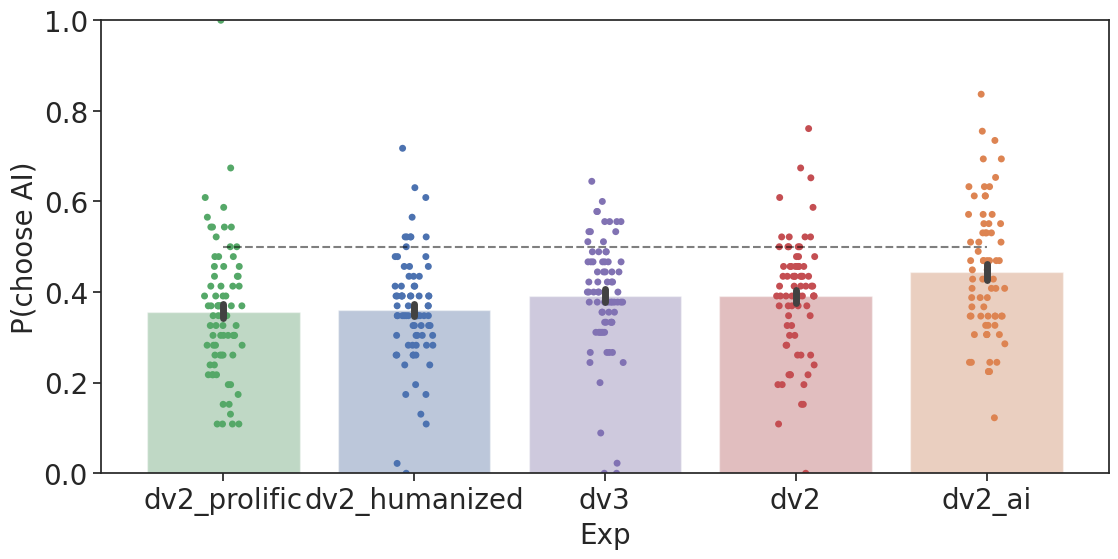

In [91]:
sns.set({'figure.figsize':(13, 6)})
sns.set_style("ticks")
order = ['dv2_prolific', 'dv2_humanized', 'dv3', 'dv2', 'dv2_ai']
colors = ['C2', 'C0', 'C4', 'C3', 'C1']
dff = df.copy()
dff.loc[dff.answer=='Not Prolific', 'answer'] = 'AI'
dff.loc[dff.q_id==2, 'chooseAI'] = dff[dff.q_id==2].answer=='AI'
df2 = dff[dff.q_id==2].groupby(['prolific_id', 'engine'], as_index=False).chooseAI.mean()

sns.barplot(x='engine', y='chooseAI', data=df2,  ci=68, errwidth=5, alpha=0.4, zorder=0, order=order, palette=colors)
sns.stripplot(x='engine', y='chooseAI', data=df2,zorder=1, order=order, palette=colors)
plt.plot([0, 4], [0.5, 0.5], '--', color='black', alpha=0.5)
plt.ylabel('P(choose AI)')
plt.ylim(0, 1)
plt.xlabel('Exp')
# pg.ttest(df2[df2.engine=='dv2_humanized'].correct, df2[df2.engine=='dv2_ai'].correct)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# pg.pairwise_ttests(dv='correct', between='engine', subject='prolific_id', data=df2, padjust='bonf', effsize='cohen', parametric=True)

<AxesSubplot:xlabel='engine', ylabel='correct'>

<AxesSubplot:xlabel='engine', ylabel='correct'>

(0.0, 1.0)

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,engine,dv2,dv2_ai,False,True,2.6147,138.4940,two-sided,0.0099,0.0992,bonf,3.902,0.4242
1,engine,dv2,dv2_humanized,False,True,4.3204,129.4213,two-sided,0.0000,0.0003,bonf,669.252,0.6956
2,engine,dv2,dv2_prolific,False,True,1.9161,153.9989,two-sided,0.0572,0.5721,bonf,0.927,0.3067
3,engine,dv2,dv3,False,True,-3.1782,149.5827,two-sided,0.0018,0.0180,bonf,16.51,-0.5142
4,engine,dv2_ai,dv2_humanized,False,True,1.8884,142.8580,two-sided,0.0610,0.6100,bonf,0.894,0.3093
5,engine,dv2_ai,dv2_prolific,False,True,-0.4314,140.5983,two-sided,0.6669,1.0000,bonf,0.191,-0.0692
6,engine,dv2_ai,dv3,False,True,-6.0150,131.2002,two-sided,0.0000,0.0000,bonf,7.551e+05,-0.9789
7,engine,dv2_humanized,dv2_prolific,False,True,-2.0083,156.0000,two-sided,0.0463,0.4634,bonf,1.088,-0.3195
8,engine,dv2_humanized,dv3,False,True,-7.7633,121.0037,two-sided,0.0000,0.0000,bonf,5.79e+09,-1.2591
9,engine,dv2_prolific,dv3,False,True,-4.9912,151.4819,two-sided,0.0000,0.0000,bonf,9024.788,-0.8029


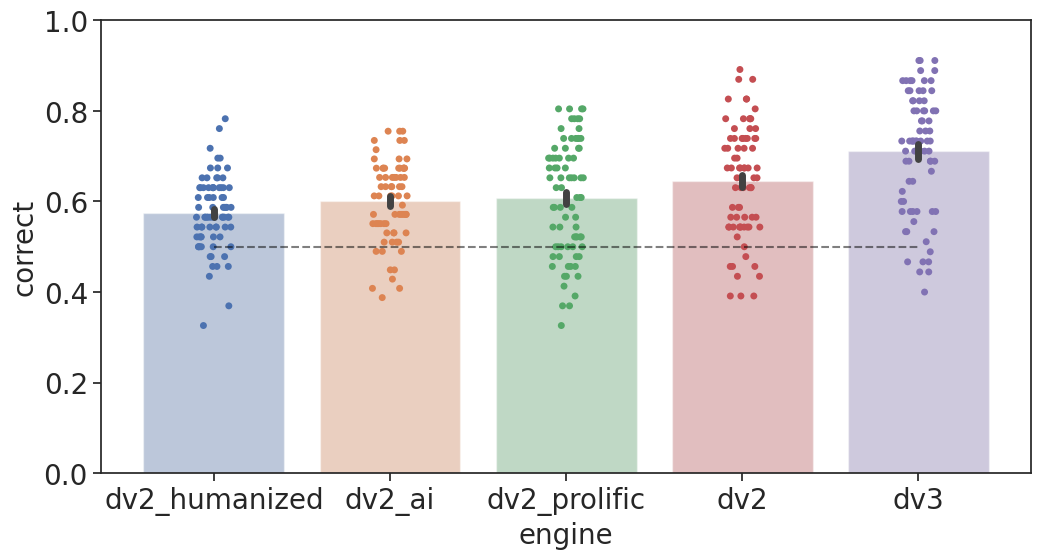

In [92]:
sns.set({'figure.figsize':(12, 6)})
sns.set_style("ticks")
df2 = df[df.q_id==2].groupby(['prolific_id', 'engine'], as_index=False).correct.mean()

sns.barplot(x='engine', y='correct', data=df2, order=['dv2_humanized', 'dv2_ai', 'dv2_prolific', 'dv2', 'dv3'], ci=68, errwidth=5, alpha=0.4, zorder=0)
sns.stripplot(x='engine', y='correct', data=df2, order=['dv2_humanized', 'dv2_ai', 'dv2_prolific', 'dv2', 'dv3'], zorder=1)
plt.plot([0, 4], [0.5, 0.5], '--', color='black', alpha=0.5)
plt.ylim(0, 1)
# pg.ttest(df2[df2.engine=='dv2_humanized'].correct, df2[df2.engine=='dv2_ai'].correct)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pg.pairwise_ttests(dv='correct', between='engine', subject='prolific_id', data=df2, padjust='bonf', effsize='cohen', parametric=True)

In [77]:
df_all = pd.read_csv('H+GPT3/all_final.csv')
sns.set(
    rc={'figure.figsize':(23,12), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 13
        , 'ytick.labelsize': 13, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})

df_all['agree_a0'] = df_all.a0.str.contains('yes')
df_AI = df_all[df_all.source=='AI'].groupby(['title', 'cond'], as_index=False).agree_a0.mean().sort_values('title', ascending=False).rename(columns={'agree_a0': 'AI'})
df_Human = df_all[df_all.source=='Human'].groupby(['title', 'cond'], as_index=False).agree_a0.mean().sort_values('title', ascending=False).rename(columns={'agree_a0': 'H'})
diff = pd.concat([df_AI, df_Human.H], axis=1)
diff['diff'] = diff.AI - diff.H
# df_AI.drop('item_id', axis=1, inplace=True)
# df_Human.drop('item_id', axis=1, inplace=True)
# corr.corr()
diff['item_id'] = diff.index


# plt.subplot(2, 1, 1)
# sns.barplot(x='item_id', y='diff', data=diff, hue='cond', order=diff.sort_values(['diff', 'cond'], ascending=False).index)
# plt.ylabel('delta (AI - Human) agreement')
# # sns.heatmap(abs(df_AI.AI - df_Human.H), annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar=False)

# plt.subplot(2, 2, 3)
# sns.scatterplot(x='AI', y='H', data=diff, hue='cond', legend=False)
# plt.annotate(f'corr={round(diff.corr().H.values[0], 2)}', xy=(.2, .5))


## add similarity score to df where title is the same in diff
# check if diff.title contains Sophie's Choice 
df.loc[df['title'].str.contains('Sophie'), 'title'] = 'Sophie Choice'
diff.loc[diff['title'].str.contains('Sophie'), 'title'] = 'Sophie Choice'
df['sim_score'] = df.title.apply(lambda x: diff[diff.title.str.contains(x)]['diff'].values[0])




/tmp/ipykernel_1408535/3622980328.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


<AxesSubplot:>

(0.0, 1.0)

(-0.1, 1.1)

([<matplotlib.axis.XTick at 0x7f6dd45d96d0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

Text(0.5, 1.0, 'Turing Test Accuracy')

([], [])

Text(0.5, 0, 'Source')

<AxesSubplot:>

(0.0, 1.0)

(-0.1, 1.1)

([<matplotlib.axis.XTick at 0x7f6dc33ef430>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

Text(0.5, 1.0, 'Agreement (Yes/No)')

([], [])

Text(0.5, 0, 'Source')

<AxesSubplot:>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement (Justification)')

([<matplotlib.axis.XTick at 0x7f6dc3770c40>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

([], [])

Text(0.5, 0, 'Source')

<AxesSubplot:>

(0.0, 100000.0)

Text(0.5, 1.0, 'RT (ms)')

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'Source')

Text(0.5, 1.05, 'dv2_ai')

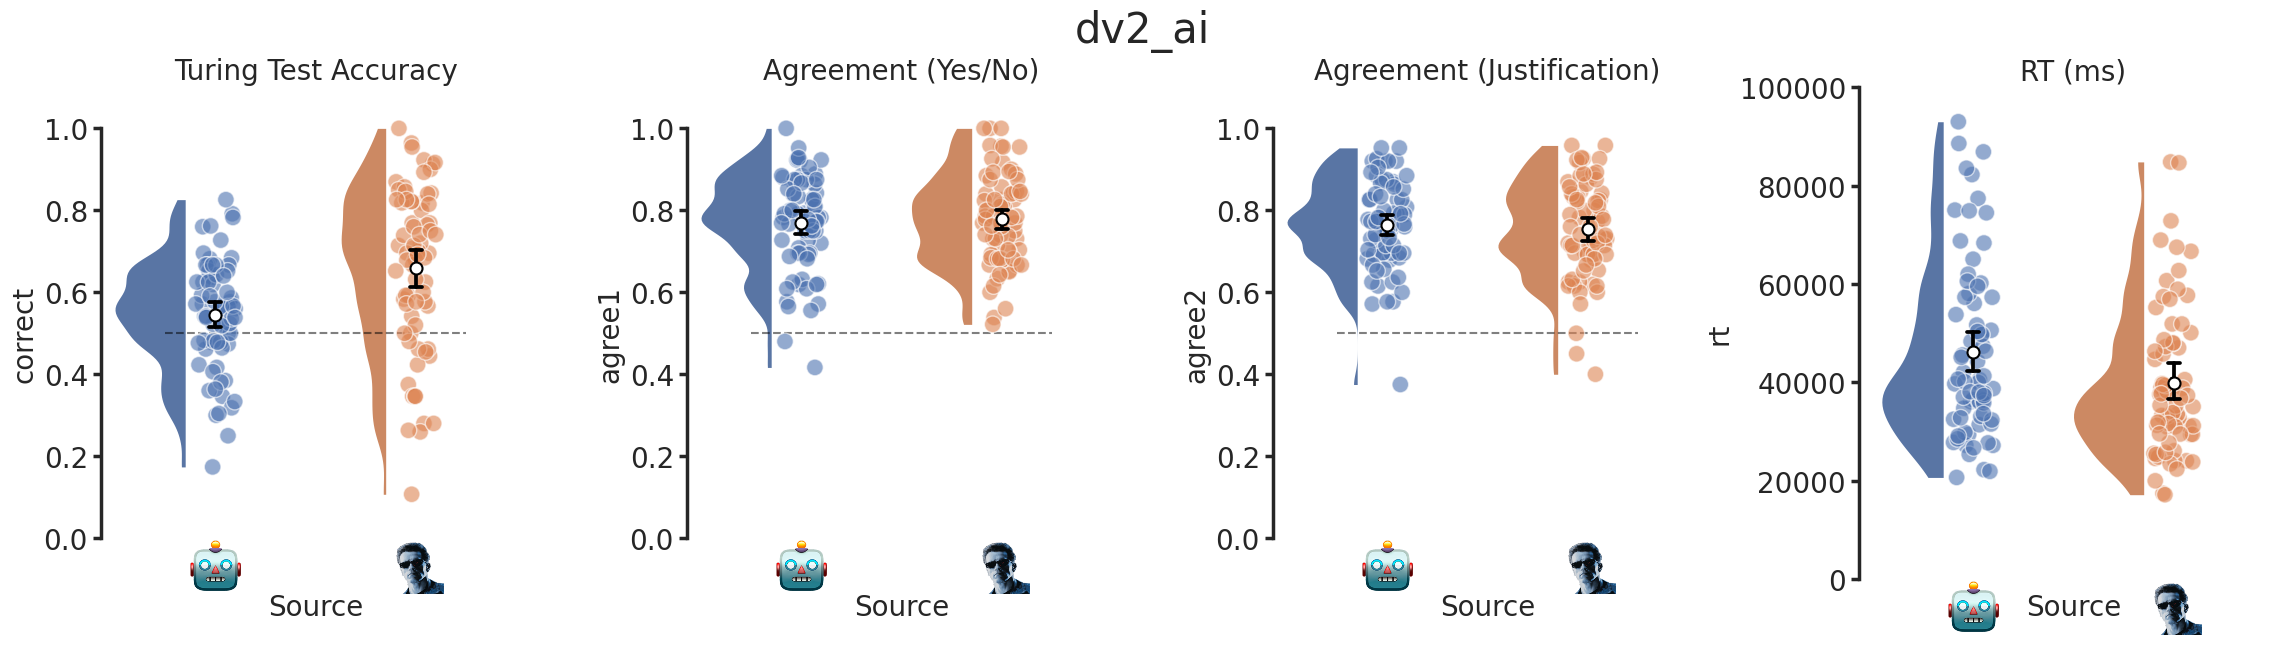

In [94]:
sns.set(
    rc={'figure.figsize':(23,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5

engine = 'dv2_ai'

# -------------------------------------------------------------------------------
# Plot 1: Turing Test 
# -------------------------------------------------------------------------------
avg = df[(df.engine==engine)& (df.q_id==2)].groupby(['prolific_id', 'source'], as_index=False).correct.mean()
plt.subplot(1, 4, 1)
# sns.barplot(x='source', y='correct', data=avg, errorbar='se'
# sns.stripplot(x='source', y='correct', data=avg, alpha=0.5, jitter=0.1, size=15, color='black')
#
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='correct', markersize=12, df=avg)
plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.title('Turing Test Accuracy')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);

plt.xlabel('Source')

# AI correct and Human correct is significantly diff
# print(pg.ttest(avg[avg.source=='AI'].correct, avg[avg.source=='Human'].correct, paired=True))
# n = len(avg[avg.source=='AI'].correct)
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='AI'].correct))
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='Human'].correct))

# -------------------------------------------------------------------------------
# Plot 2: Agreement 1
# -------------------------------------------------------------------------------
avg = df[(df.engine==engine)].groupby(['prolific_id', 'source'], as_index=False).agree1.mean()
plt.subplot(1, 4, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree1', markersize=12, df=avg)
# sns.barplot(x='source', y='agree1', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree1', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.title('Agreement (Yes/No)')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
# AI agree1 and Human agree1 is significantly diff
sources = avg.source.unique()

plt.xlabel('Source')
# print(f'{sources[0]} vs {sources[1]}')
# print(pg.ttest(avg[avg.source==sources[0]].agree1, avg[avg.source==sources[1]].agree1, paired=True))
# n = len(avg[avg.source=='AI'].correct)
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='AI'].correct))
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='Human'].correct))

# -------------------------------------------------------------------------------
# Plot 3: Agreement 2
# -------------------------------------------------------------------------------
avg = df[(df.engine==engine)].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 3)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree2', markersize=12, df=avg)
# sns.barplot(x='source', y='agree2', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree2', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xlabel('Source')
# AI agree2 and Human agree2 is significantly diff
# print(pg.ttest(avg[avg.source=='AI'].agree2, avg[avg.source=='Human'].agree2, paired=True))


# -------------------------------------------------------------------------------
# Plot 4: RT
# -------------------------------------------------------------------------------
plt.subplot(1, 4, 4)
# plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# plt.plot([-1, 2], [0.5, 0.5], '--', color='black', alpha=0.5)
#sns.barplot(x='source', y='rt', data=avg, errorbar='se')
#sns.stripplot(x='source', y='rt', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
raincloud(x='source', y='rt', markersize=12, df=avg)
plt.ylim(0, 100000)
plt.title('RT (ms)')
plt.xlabel('')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)

sns.despine(offset=10, trim=True, bottom=True);
plt.xlabel('Source')


plt.tight_layout()
plt.suptitle(engine, fontsize=30, y=1.05)

# ADD CORRECTNESS SCORE

In [44]:
print(list(df.item_id.unique()))

# import html
# html.unescape(a2)

[104, 130, 106, 103, 128, 105, 120, 114, 111, 119, 163, 122, 136, 172, 94, 155, 137, 154, 141, 134, 185, 124, 153, 193, 102, 107, 146, 140, 200, 157, 158, 115, 178, 205, 177, 135, 164, 228, 167, 184, 202, 149, 212, 93, 143, 148, 216, 174, 209, 166, 160, 181, 173, 223, 182, 229, 145, 116, 168, 159, 231, 131, 151, 144, 226, 171, 233, 165, 214, 138, 152, 192, 121, 176, 161, 101, 213, 142, 170, 113, 189, 186, 204, 156, 162, 198, 147, 150, 203, 96, 179, 222, 108, 183, 206, 169, 217, 180, 218, 187, 207, 188, 195, 191, 224, 210, 211, 201, 112, 117, 194, 230, 199, 109, 232, 126, 197, 219, 215, 190, 98, 220, 139, 227, 132, 95, 196, 225, 221, 208, 97, 133, 110, 123, 118, 99, 125, 129, 244, 268, 269, 240, 256, 261, 274, 267, 257, 259, 254, 265, 234, 249, 255, 246, 241, 271, 272, 248, 270, 275, 250, 253, 266, 276, 264, 245, 263, 247, 235, 277, 237, 251, 252, 236, 243, 260, 238, 279, 273, 262, 278, 258, 242, 239, 311, 289, 314, 321, 325, 312, 303, 300, 290, 294, 284, 323, 318, 299, 285, 320, 324, 3

NameError: name 'a2' is not defined

In [159]:
def rule(x):
   dic = ['HIV', 'Mrs', 'VCR', 'Monday', 'Santiago', 'Morris']
   err = []
   for m in tool.check(x):
         if m.category in ('TYPOS', 'GRAMMAR') and m.ruleId not in ('UPPERCASE_SENTENCE_START', 'I_LOWERCASE'):
            if any(el in m.replacements for el in dic): 
               continue
            err.append(m)
   return len(err)

# df = df[df.engine=='dv2_ai']
unique_a1 = df.a1.unique()
new_df = pd.DataFrame({'a1': unique_a1, 'correctness': [None, ]*len(unique_a1)})
with ltp.LanguageTool('en-US', remote_server='http://localhost:8081') as tool:
    new_df['correctness'] = new_df.a1.apply(rule)
print('Finished checking correctness, apply to dv2 and dv3')
df['correctness'] = df.a1.apply(lambda x: new_df[new_df.a1==x].correctness.values[0])
#dv3['correctness'] = dv3.a1.apply(lambda x: new_df[new_df.a1==x].correctness.values[0])
#dv2.to_csv('HUMANS/dv2_77.csv')
#dv3.to_csv('HUMANS/dv3_76.csv')
# df[df.engine=='dv2_humanized'].to_csv('dv2_humanized_correctness.csv')

Finished checking correctness, apply to dv2 and dv3


<AxesSubplot:xlabel='source', ylabel='correctness'>

Text(0, 0.5, 'Errors')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-9.8172,298,two-sided,0.0000,"[-0.17, -0.12]",1.1336,5.786e+16,1.0000


array([ 2,  3,  4,  5,  6,  8,  9, 11, 13, 12, 17, 19, 18, 16, 20, 21, 24,
       27, 30, 33, 42, 25, 32, 28, 43, 46, 54, 56, 58, 64, 50, 65,  1,  7,
       14, 15, 23, 22, 29, 26, 34, 35, 36, 38, 40, 44, 47, 49, 41, 52, 51,
       48, 57, 53, 59, 60, 61, 37, 39, 62, 45, 55, 63, 66, 67, 10, 69, 68,
       70, 71, 72, 31, 75, 73,  0, 76, 74])

,respondent_id,source,engine,dataset_id,id_first,item_idx,item_id,q_id,rt,correct,agree1,agree2,choseLeft,correctness
0,0,AI,dv2_ai,35.5263,0.6579,25.4474,1862.1316,2.0000,50383.9211,0.5000,0.7368,0.7632,0.6053,0.0000
1,0,Human,dv2_ai,37.1053,0.5526,24.9474,1815.1053,2.0000,43626.3947,0.5789,0.6842,0.7105,0.5000,0.4211
2,1,AI,dv2_ai,28.1892,0.5135,27.2973,1582.7027,2.0000,43011.6486,0.6486,0.7027,0.7297,0.4054,0.0811
3,1,Human,dv2_ai,37.1951,0.6341,21.2683,1709.3171,2.0000,32521.4390,0.6098,0.8537,0.8293,0.4634,0.3659
4,2,AI,dv2_ai,31.0541,0.5405,25.8378,1545.3514,2.0000,59214.1892,0.5946,0.7027,0.7297,0.5676,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,8.0,AI,dv3,37.0556,0.4815,22.6296,1758.3704,2.0000,136107.9815,0.5556,0.8519,0.7963,NaN,0.1481
296,9.0,AI,dv2,40.5593,0.5085,22.0678,1901.2542,2.0000,40610.0339,0.5932,0.7966,0.7627,NaN,0.0678
297,9.0,AI,dv2_humanized,41.1404,0.4737,23.2807,1940.0000,2.0000,36635.3158,0.3509,0.8246,0.7719,0.6491,0.2982
298,9.0,AI,dv2_prolific,41.1404,0.4211,21.9123,1940.0000,2.0000,45570.4211,0.4737,0.8246,0.7368,0.5088,0.0702


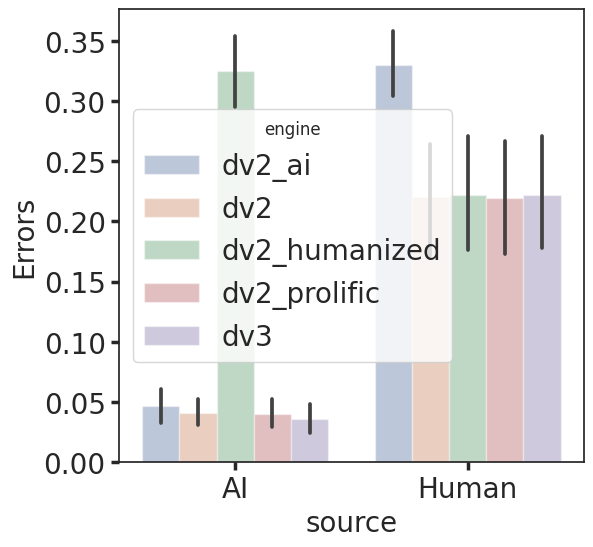

In [160]:
# df = pd.concat([dv2_ai, dv2_humanized], axis=0)
# df = dv2_humanized
# df.shape[0]/3
df2 = df[df.q_id==2].groupby(['respondent_id', 'source', 'engine'], as_index=False).mean()
sns.set({'figure.figsize': (6, 6)})
sns.set_style('ticks')
sns.barplot(x='source', y='correctness', hue='engine', data=df2, alpha=0.4)
# sns.stripplot(x='source', y='correctness', hue='engine', data=df, alpha=0.7, jitter=0.1, size=5, zorder=1)
plt.ylabel('Errors')
# plt.ylim(0, 6 )
pg.ttest(df2[df2.source=='AI'].correctness, df2[df2.source=='Human'].correctness, paired=False)
df.dataset_id.unique()
df2

,source,engine,dataset_id,id_first,item_idx,item_id,q_id,rt,choseLeft
0,AI,dv2,37.726655,0.490662,22.554612,1744.932654,1.0,41761.219015,NaN
1,AI,dv2_ai,17.585216,0.484600,23.724846,1818.478439,1.0,52978.870637,0.498289
2,AI,dv2_humanized,38.231031,0.496602,22.727633,1804.070215,1.0,39429.835787,0.498112
3,AI,dv2_prolific,37.301657,0.495580,22.440884,1760.807735,1.0,41863.607182,0.488398
4,AI,dv3,37.102238,0.523896,22.032668,1759.416818,1.0,44050.851785,NaN
5,Human,dv2,37.225352,0.490141,22.445634,1722.030423,1.0,39315.578028,NaN
6,Human,dv2_ai,18.111562,0.529412,24.271805,1804.647059,1.0,44640.208925,0.521974
7,Human,dv2_humanized,37.770270,0.497748,22.273649,1781.603604,1.0,39853.650338,0.510886
8,Human,dv2_prolific,36.776316,0.513706,22.558662,1735.283991,1.0,37703.255482,0.498721
9,Human,dv3,37.872100,0.499151,21.969440,1795.735144,1.0,38326.691002,NaN


array([True, False], dtype=object)

/tmp/ipykernel_1408535/1206905378.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


<AxesSubplot:xlabel='engine', ylabel='d_prime'>

<AxesSubplot:xlabel='engine', ylabel='d_prime'>

Text(0.5, 0, 'exp')

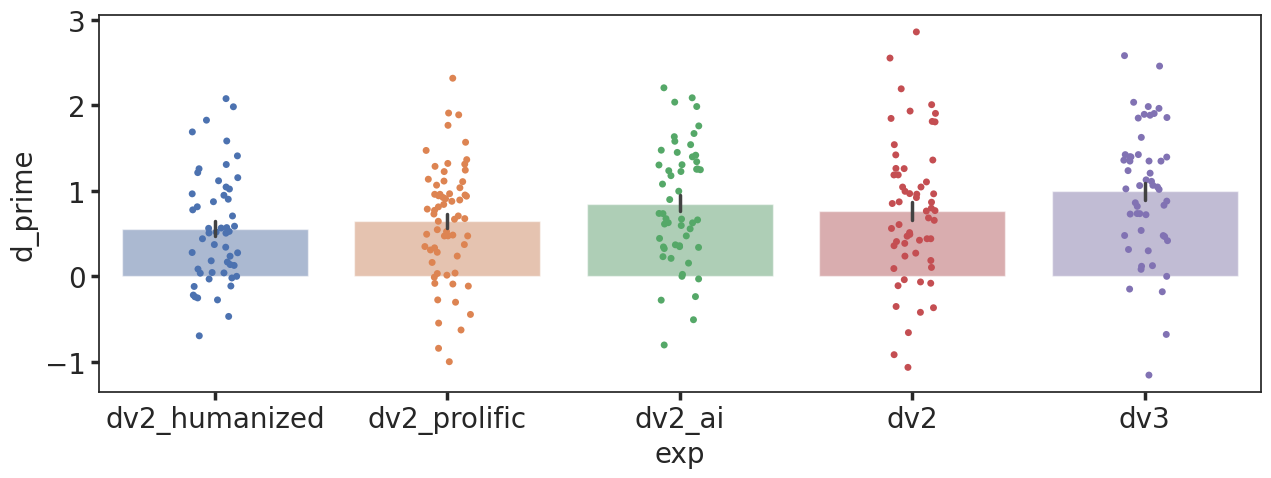

<AxesSubplot:>

(-3.0, 3.0)

Text(0.5, 1.0, 'Agreement (Yes/No)')

           n       r          CI95%  p-val   BF10  power
pearson  280 -0.0106  [-0.13, 0.11] 0.8596  0.076 0.0535
                            OLS Regression Results                            
Dep. Variable:                 agree1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.03133
Date:                Wed, 14 Jun 2023   Prob (F-statistic):              0.860
Time:                        16:32:44   Log-Likelihood:                 212.56
No. Observations:                 280   AIC:                            -421.1
Df Residuals:                     278   BIC:                            -413.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

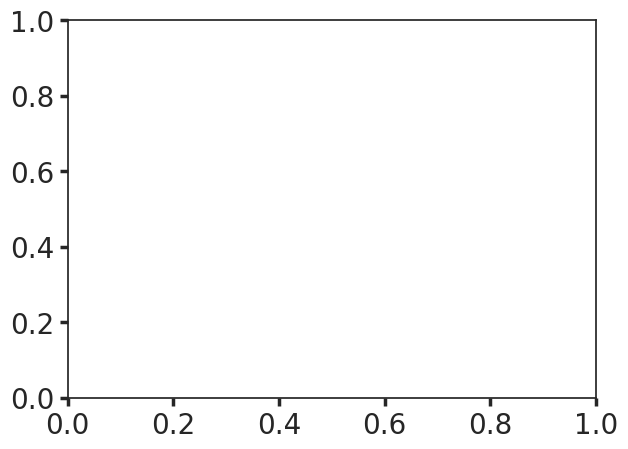

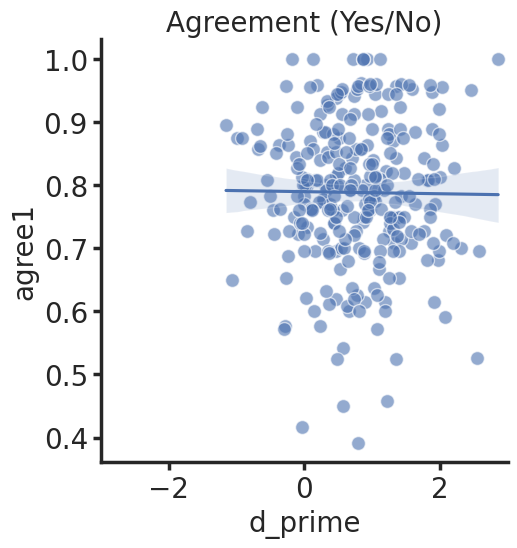

<AxesSubplot:>

(-3.0, 3.0)

Text(0.5, 1.0, 'Agreement (Justification)')

           n       r         CI95%  p-val   BF10  power
pearson  280 -0.0141  [-0.13, 0.1] 0.8141  0.077 0.0563
                            OLS Regression Results                            
Dep. Variable:                 agree2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.05541
Date:                Wed, 14 Jun 2023   Prob (F-statistic):              0.814
Time:                        16:32:45   Log-Likelihood:                 176.21
No. Observations:                 280   AIC:                            -348.4
Df Residuals:                     278   BIC:                            -341.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

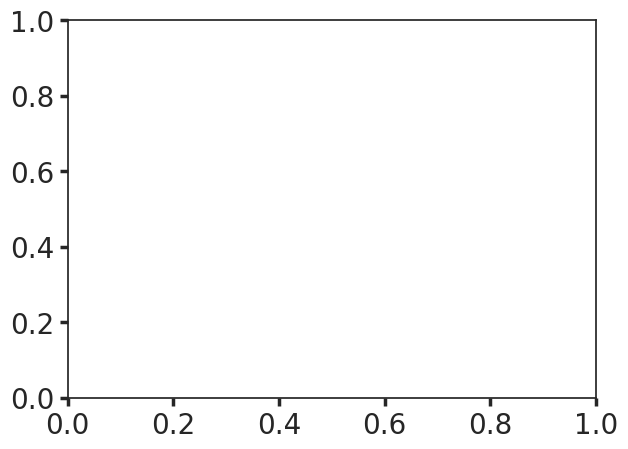

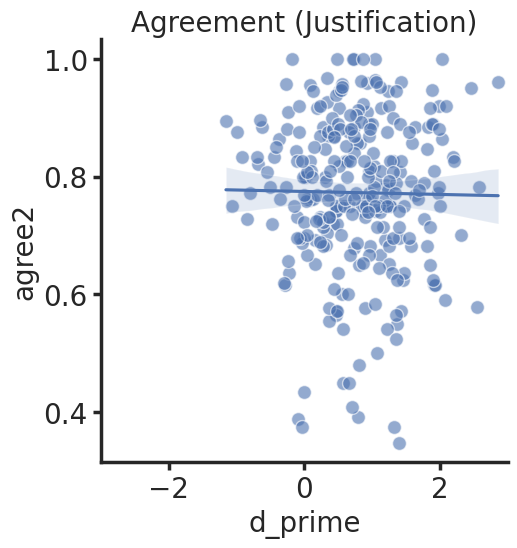

In [97]:
import scipy.stats as stats

sns.set(
    rc={'figure.figsize':(35,6), "figure.dpi": 100, 'legend.fontsize': 20,
        'axes.labelsize': 20, 'axes.titlesize': 20,
        'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
        'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5

false = pd.DataFrame()
hits = pd.DataFrame()

df['correct'] = df.correct.astype(int)
df['agree1'] = df.agree1.astype(int)
df['agree2'] = df.agree2.astype(int)

labels = ['id', 'agree1', 'agree2']
labels = ['id']
titles = ['Agreement (Yes/No)', 'Agreement (Justification)']

false['id'] = 1 - df[(df.source == 'Human') & (df.q_id == 2)
                     ].groupby('prolific_id', as_index=False).mean().correct
false['engine'] = df[(df.source == 'Human') & (df.q_id == 2)].groupby(['prolific_id', 'engine'], as_index=False).mean().engine
false['prolific_id'] = df[(df.source == 'Human') & (df.q_id == 2)].groupby('prolific_id', as_index=False).mean().prolific_id

hits['id'] = df[(df.source == 'AI') & (df.q_id == 2)].groupby(
    'prolific_id', as_index=False).mean().correct
hits['engine'] = df[(df.source == 'AI') & (df.q_id == 2)].groupby(['prolific_id', 'engine'],as_index=False).mean().engine
hits['prolific_id'] = df[(df.source == 'AI') & (df.q_id == 2)].groupby('prolific_id', as_index=False).mean().prolific_id

false['agree1'] = 1 - df[(df.source == 'Human') & (df.q_id == 2)
                         ].groupby('prolific_id', as_index=False).mean().agree1

hits['agree1'] = df[(df.source == 'AI') & (df.q_id == 2)].groupby(
    'prolific_id', as_index=False).mean().agree1
false['agree2'] = 1 - df[(df.source == 'Human') & (df.q_id == 2)
                         ].groupby('prolific_id', as_index=False).mean().agree2
hits['agree2'] = df[(df.source == 'AI') & (df.q_id == 2)].groupby(
    'prolific_id', as_index=False).mean().agree2

d = []
for i in range(false['id'].shape[0]):
    d.append({'agree1': hits['agree1'].values[i],
              'agree2': hits['agree2'].values[i],
              'engine': hits['engine'].values[i],
              'prolific_id': hits['prolific_id'].values[i],
              'd_prime': float(stats.norm.ppf(hits['id'].values[i]) - stats.norm.ppf(false['id'].values[i]))})

d = pd.DataFrame(d)  # plt.subplot(1, 4, 1)
d = d[~d.isin([np.nan, np.inf, -np.inf]).any(1)]

sns.set({'figure.figsize': (15,5), "figure.dpi": 100, 'legend.fontsize': 20,})
sns.set_style('ticks')
sns.barplot(x='engine', y='d_prime', data=d, ci=68, alpha=.5, errwidth=2.5, edgecolor='white', order=['dv2_humanized','dv2_prolific', 'dv2_ai', 'dv2', 'dv3'], zorder=0)
sns.stripplot(x='engine', y='d_prime', data=d, edgecolor='white', order=['dv2_humanized','dv2_prolific', 'dv2_ai', 'dv2', 'dv3'], zorder=1)
plt.xlabel('exp')
# plt.ylim(0,1.5)
plt.show()

count = 0
d['d_prime'] = d['d_prime'].astype(float)
d['agree1'] = d['agree1'].astype(float)
for agree in ('agree1', 'agree2'):
    count += 1
    # plt.clear()
    plt.subplot(1, 2, count)
    sns.lmplot(x='d_prime', y=agree, data=d, scatter_kws={
               'alpha': 0.6, 's': 100, 'edgecolor': 'white'})
# snspine(offset=10, trim=True)
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)
    plt.xlim([-3, 3])
    plt.title(titles[count-1])
    print(pg.corr(d['d_prime'], d[agree]))
    print(sm.formula.ols(f'{agree} ~ d_prime', data=d).fit().summary())
    plt.show()

# add d_prime to the original dataframe to the corresponding prolific_id
def f(x):
    try:
        return d[d.prolific_id == x.prolific_id].d_prime.values[0]
    except:
        return np.NaN

# df['d_prime'] = df.apply(f, axis=1)
# for i in df.prolific_id.unique():
    # print(i)
    # assert d.prolific_id.isin([i]).any()

,d_prime,anti_AI_bias
d_prime,1.000000,-0.377711
anti_AI_bias,-0.377711,1.000000


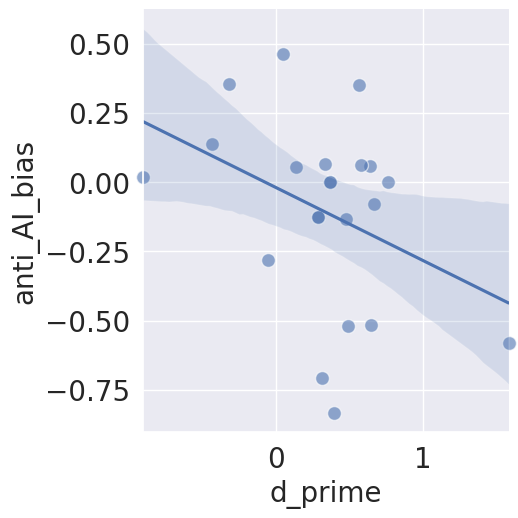

In [52]:
df2 = df[(df.source == 'Human') & (df.q_id == 2) & (df.engine=='dv2_humanized')].groupby(['prolific_id', 'correct'], as_index=False).mean()
new_df = []
for i in df2.prolific_id.unique():
    # new_df['antiAI'] =     print(i)
    # df2[(df2.correct == True) & (df2.prolific_id == i)]
    try:
        new_df.append({
            'd_prime': df2[df2.prolific_id == i].d_prime.values[0],
            'anti_AI_bias': df2[(df2.correct==False) & (df2.prolific_id==i)].agree2.values[0] - df2[(df2.correct == True) & (df2.prolific_id == i)].agree2.values[0]
        })
    except:
        continue

# sns.displot(antiAI)
new_df = pd.DataFrame(new_df)

sns.lmplot(x='d_prime', y='anti_AI_bias', data=new_df, scatter_kws=
           {'clip_on': False, 'alpha': 0.6, 's': 100, 'edgecolor': 'white'})
new_df.corr()

In [134]:
sns.set({'figure.figsize':(6,6), "figure.dpi": 100, 'legend.fontsize': 20,})
df['justif_len'] = df.a1.str.len()
dff = df[(df.q_id == 2) & (df.engine=='dv2')]
dff.loc[dff.answer=='AI', 'a'] = 1
dff.loc[dff.answer=='Human', 'a'] = 0
dff.loc[dff.agree1==True, 'agree1'] = 1
dff.loc[dff.agree1==False, 'agree1'] = 0

dff['agree1'] = dff['agree1'].astype(float)
print(sm.Logit.from_formula('agree1 ~ justif_len*correctness*correct', data=dff).fit().summary())
#sns.lmplot(x='justif_len', y='a', data=dff, logistic=True)
#plt.ylabel('ID Answer (AI=1, Human=0)')
#plt.xlabel('justification length')
#plt.annotate('***', xy=(0, 0), fontsize=20)

Optimization terminated successfully.
         Current function value: 0.498104
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 agree1   No. Observations:                 3542
Model:                          Logit   Df Residuals:                     3534
Method:                           MLE   Df Model:                            7
Date:                Tue, 23 May 2023   Pseudo R-squ.:                 0.01573
Time:                        18:01:37   Log-Likelihood:                -1764.3
converged:                       True   LL-Null:                       -1792.5
Covariance Type:            nonrobust   LLR p-value:                 7.903e-10
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.9282   

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_1341153/297445386

<AxesSubplot:xlabel='answer', ylabel='dataset_id'>

<AxesSubplot:xlabel='answer', ylabel='dataset_id'>

Text(0, 0.5, 'N trials')

Text(0.5, 1.0, 'dv2')

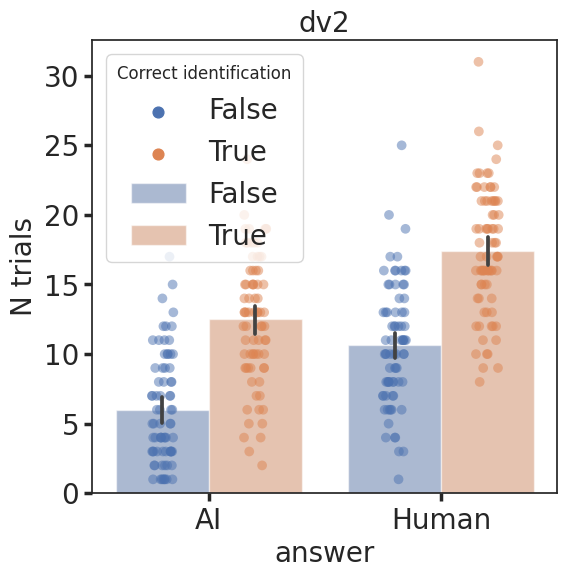

In [27]:
engine = 'dv2'
df2 = df[(df.engine==engine) & (df.q_id==2)].groupby(['prolific_id', 'answer', 'correct'], as_index=False).count()
sns.set({'figure.figsize':(6, 6), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')


sns.barplot(x='answer', y='dataset_id', data=df2, hue='correct', dodge=True, alpha=.5, zorder=0)
sns.stripplot(x='answer', y='dataset_id', data=df2, alpha=0.5, jitter=0.1, size=7, hue='correct', dodge=True, zorder=1)
plt.ylabel('N trials')
plt.title(engine)    
plt.legend(title='Correct identification')

Size of dv2_ai dataset:  90.66666666666667


<AxesSubplot:>

<AxesSubplot:xlabel='source', ylabel='agree1'>

<AxesSubplot:xlabel='source', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f90bb2b85e0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'Source')

ANOVA: VAR=agree1, ENGINE=dv2_ai


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,source,0.045920,1,56,0.045920,0.933061,0.338222,0.338222,0.002568,1.0
1,correct,0.015715,1,56,0.015715,0.297208,0.587803,0.587803,0.000880,1.0
2,source * correct,0.129971,1,56,0.129971,1.464582,0.231286,0.231286,0.007234,1.0


<AxesSubplot:>

<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 2 (Justification)')

([<matplotlib.axis.XTick at 0x7f90bcba6040>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'Source')

ANOVA: VAR=agree2, ENGINE=dv2_ai


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,source,0.000291,1,56,0.000291,0.005416,0.941595,0.941595,0.000013,1.0
1,correct,0.035734,1,56,0.035734,0.418675,0.520242,0.520242,0.001621,1.0
2,source * correct,0.160306,1,56,0.160306,1.136146,0.291042,0.291042,0.007231,1.0


Text(0.5, 1.01, 'dv2_ai')

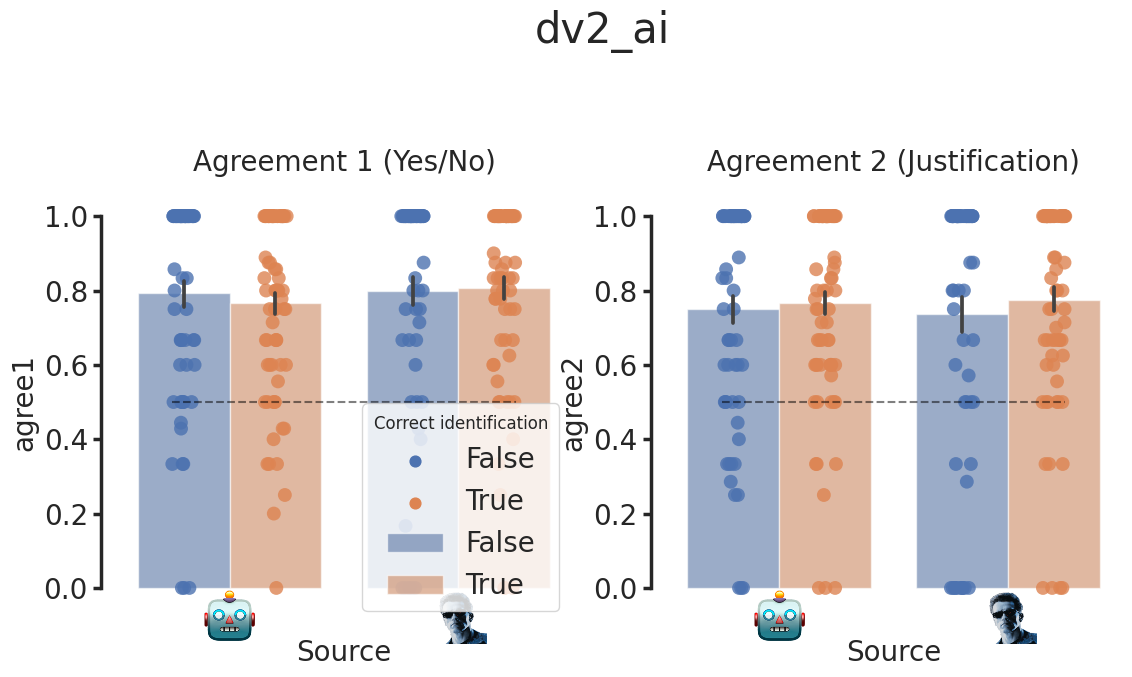

In [54]:

sns.set(
    rc={'figure.figsize':(13,13), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------
engine = 'dv2_ai'
# ids = np.random.choice(df[(df.engine==engine) & (df.q_id==2) & (df.cond!='non_moral')].prolific_id.unique(), 20, replace=False)
avg = df[(df.engine==engine) & (df.q_id == 2) & (df.cond=='impersonal_moral')].groupby(['prolific_id', 'source', 'correct'], as_index=False).mean()
print(f'Size of {engine} dataset: ', avg.shape[0]/3)

plt.subplot(2, 2, 1)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree1', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0, dodge=True)
sns.stripplot(x='source', y='agree1', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement 1 (Yes/No)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)

plt.xlabel('Source')
# plt.legend([], [], frameon=False)
print(f'ANOVA: VAR=agree1, ENGINE={engine}')
pg.rm_anova(data=avg, dv='agree1', within=['source', 'correct'], subject='prolific_id', detailed=True)
plt.legend(title='Correct identification')


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# ------------------------------------------------------------------------------
plt.subplot(2, 2, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree2', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0)
sns.stripplot(x='source', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1, edgecolor='white')
plt.ylim(-.1, 1.1)
plt.title('Agreement 2 (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.legend([], [], frameon=False)
plt.xlabel('Source')
print(f'ANOVA: VAR=agree2, ENGINE={engine}')
pg.rm_anova(data=avg, dv='agree2', within=['source', 'correct'], subject='prolific_id', detailed=True, correction='auto')
plt.suptitle(engine, fontsize=30, y=1.01)

<AxesSubplot:>

Size of dv2 dataset:  101.0


<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbee15e50>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0.5, 1.0, 'dv2')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.7221,214.0758,two-sided,0.0000,"[-0.22, -0.13]",0.8964,3.643e+10,1.0000


<AxesSubplot:>

Size of dv3 dataset:  96.33333333333333


<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbedd1d30>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0.5, 1.0, 'dv3')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.9560,233.6013,two-sided,0.0001,"[-0.13, -0.04]",0.4743,194.272,0.9800


<AxesSubplot:>

Size of dv2_prolific dataset:  102.66666666666667


<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbed39340>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0.5, 1.0, 'dv2_prolific')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.5289,193.8003,two-sided,0.0000,"[-0.26, -0.16]",0.9815,7.452e+12,1.0000


<AxesSubplot:>

Size of dv2_humanized dataset:  104.33333333333333


<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbef2abe0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0.5, 1.0, 'dv2_humanized')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.6532,245.5859,two-sided,0.0003,"[-0.11, -0.03]",0.4150,66.766,0.9554


<AxesSubplot:>

Size of dv2_ai dataset:  95.66666666666667


<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbf012c10>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'answer')

Text(0.5, 1.0, 'dv2_ai')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.6909,275.9183,two-sided,0.0076,"[-0.09, -0.01]",0.3179,3.972,0.7653


ANOVA: VAR=agree1, ENGINE=dv2


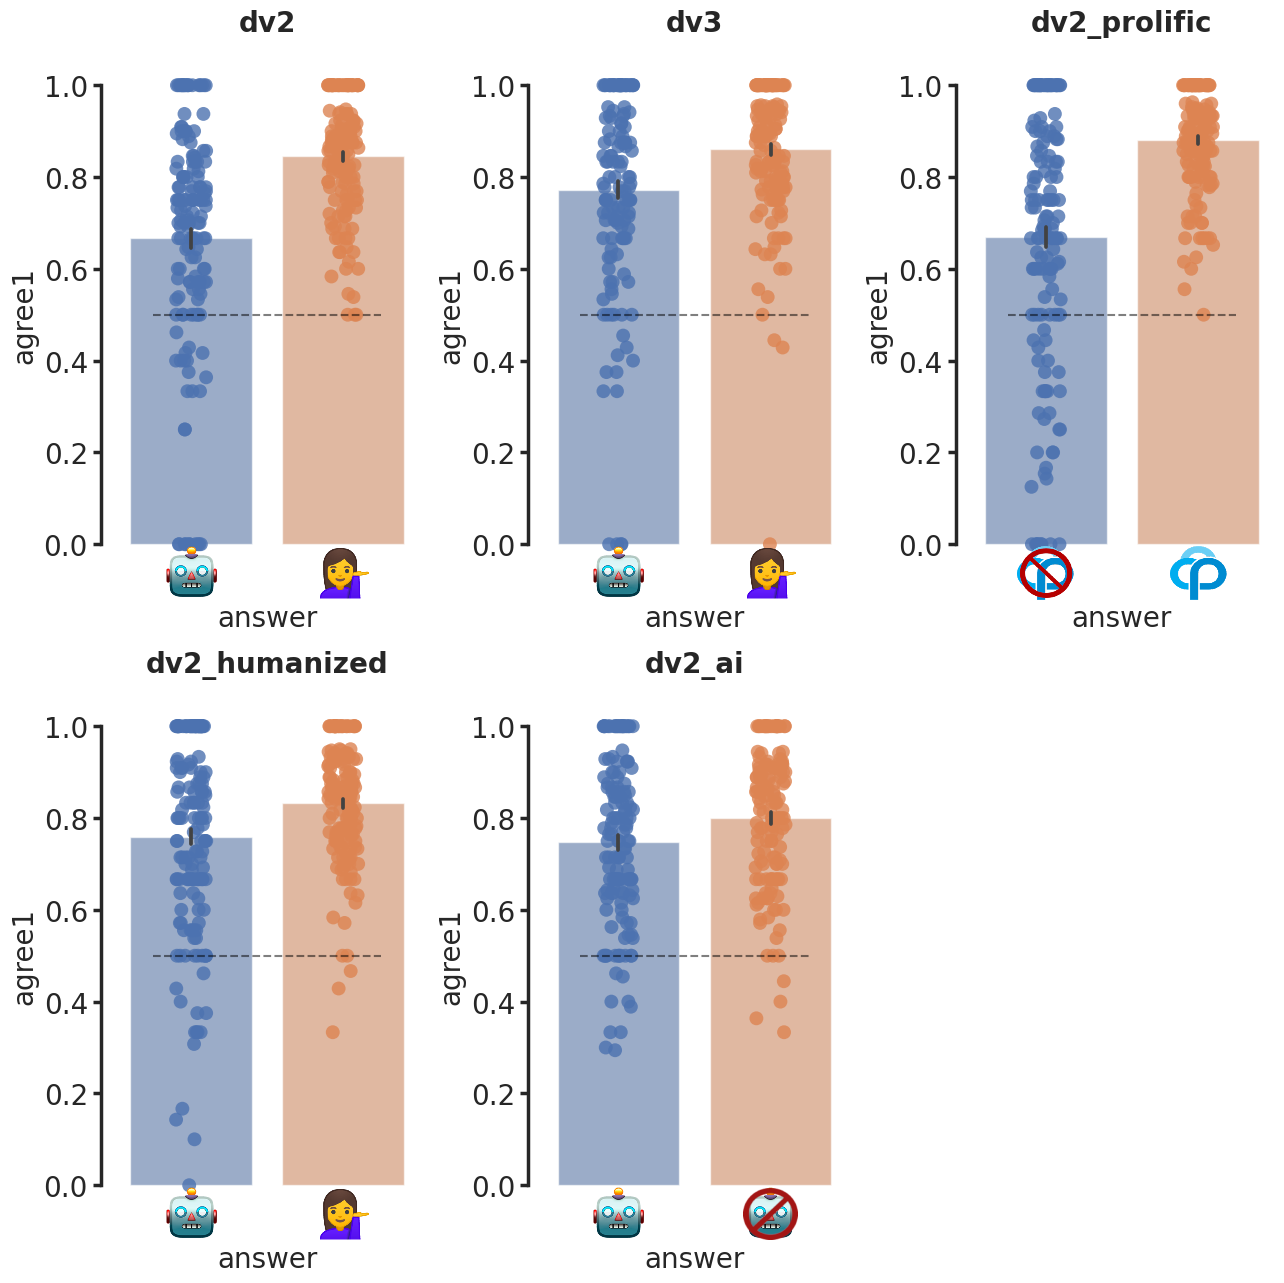

In [109]:
sns.set(
    rc={'figure.figsize':(13,13), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")


count = 0
for engine in ['dv2', 'dv3', 'dv2_prolific', 'dv2_humanized', 'dv2_ai']:
    count += 1
    plt.subplot(2, 3, count)
#
# ids = np.random.choice(df[(df.engine==engine) & (df.q_id == 0) & (df.cond!='non_moral')].prolific_id.unique(), 22, replace=False)
    avg = df[(df.engine==engine) & (df.q_id == 2)].groupby(['prolific_id', 'answer', 'correct'], as_index=False).mean()
    print(f'Size of {engine} dataset: ', avg.shape[0]/3)
    # print(avg.answer.unique())
    plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
    sns.barplot(x='answer', y='agree1', data=avg, ci=68, alpha=0.6, zorder=0, dodge=True)
    sns.stripplot(x='answer', y='agree1', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, zorder=1)
    plt.ylim(-.1, 1.1)
    plt.title('Agreement 1 (Yes/No)')
    plt.xticks(range(2), ('', ''))
    plt.xlabel('')
    plt.xticks([])
    for i, c in enumerate(avg.answer.unique()):
        offset_image(i, c, plt.gca(), size=0.3)
    sns.despine(offset=10, trim=True, bottom=True);
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)

    plt.xlabel('answer')
    plt.title(engine, fontweight='bold')
    answers = avg.answer.unique()
    pg.ttest(avg[avg.answer==answers[0]].agree1, avg[avg.answer==answers[1]].agree1, paired=True)
plt.tight_layout()
# plt.legend([], [], frameon=False)
print('ANOVA: VAR=agree1, ENGINE=dv2')
# pg.rm_anova(data=avg, dv='agree1', within=['source', 'correct'], subject='prolific_id', detailed=True)

<AxesSubplot:>

Size of dv2 dataset:  101.0


<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbef30be0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'source')

Text(0.5, 1.0, 'dv2')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.0967,262.8674,two-sided,0.2738,"[-0.02, 0.08]",0.1265,0.225,0.1952


<AxesSubplot:>

Size of dv3 dataset:  96.33333333333333


<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbefd8e20>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'source')

Text(0.5, 1.0, 'dv3')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.4357,264.8011,two-sided,0.1523,"[-0.01, 0.08]",0.1702,0.345,0.3023


<AxesSubplot:>

Size of dv2_prolific dataset:  102.66666666666667


<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbef8f400>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'source')

Text(0.5, 1.0, 'dv2_prolific')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.8883,303.7875,two-sided,0.3751,"[-0.08, 0.03]",0.1013,0.183,0.1437


<AxesSubplot:>

Size of dv2_ai dataset:  95.66666666666667


<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbf1185b0>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'source')

Text(0.5, 1.0, 'dv2_ai')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.1466,282.3996,two-sided,0.8835,"[-0.04, 0.04]",0.0173,0.131,0.0525


<AxesSubplot:>

Size of dv2_humanized dataset:  104.33333333333333


<AxesSubplot:xlabel='source', ylabel='agree2'>

<AxesSubplot:xlabel='source', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f6dbf155d30>,
 [Text(0, 0, ''), Text(1, 0, '')])

Text(0.5, 0, '')

([], [])

Text(0.5, 0, 'source')

Text(0.5, 1.0, 'dv2_humanized')

/media/getz/ae930ef3-4ac4-4a95-a76a-47e9ab0a2b27/CodeProjects/Python/CognitiveReflection/venv/lib/python3.8/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.3299,310.9997,two-sided,0.1845,"[-0.07, 0.01]",0.1503,0.29,0.2635


ANOVA: VAR=agree1, ENGINE=dv2


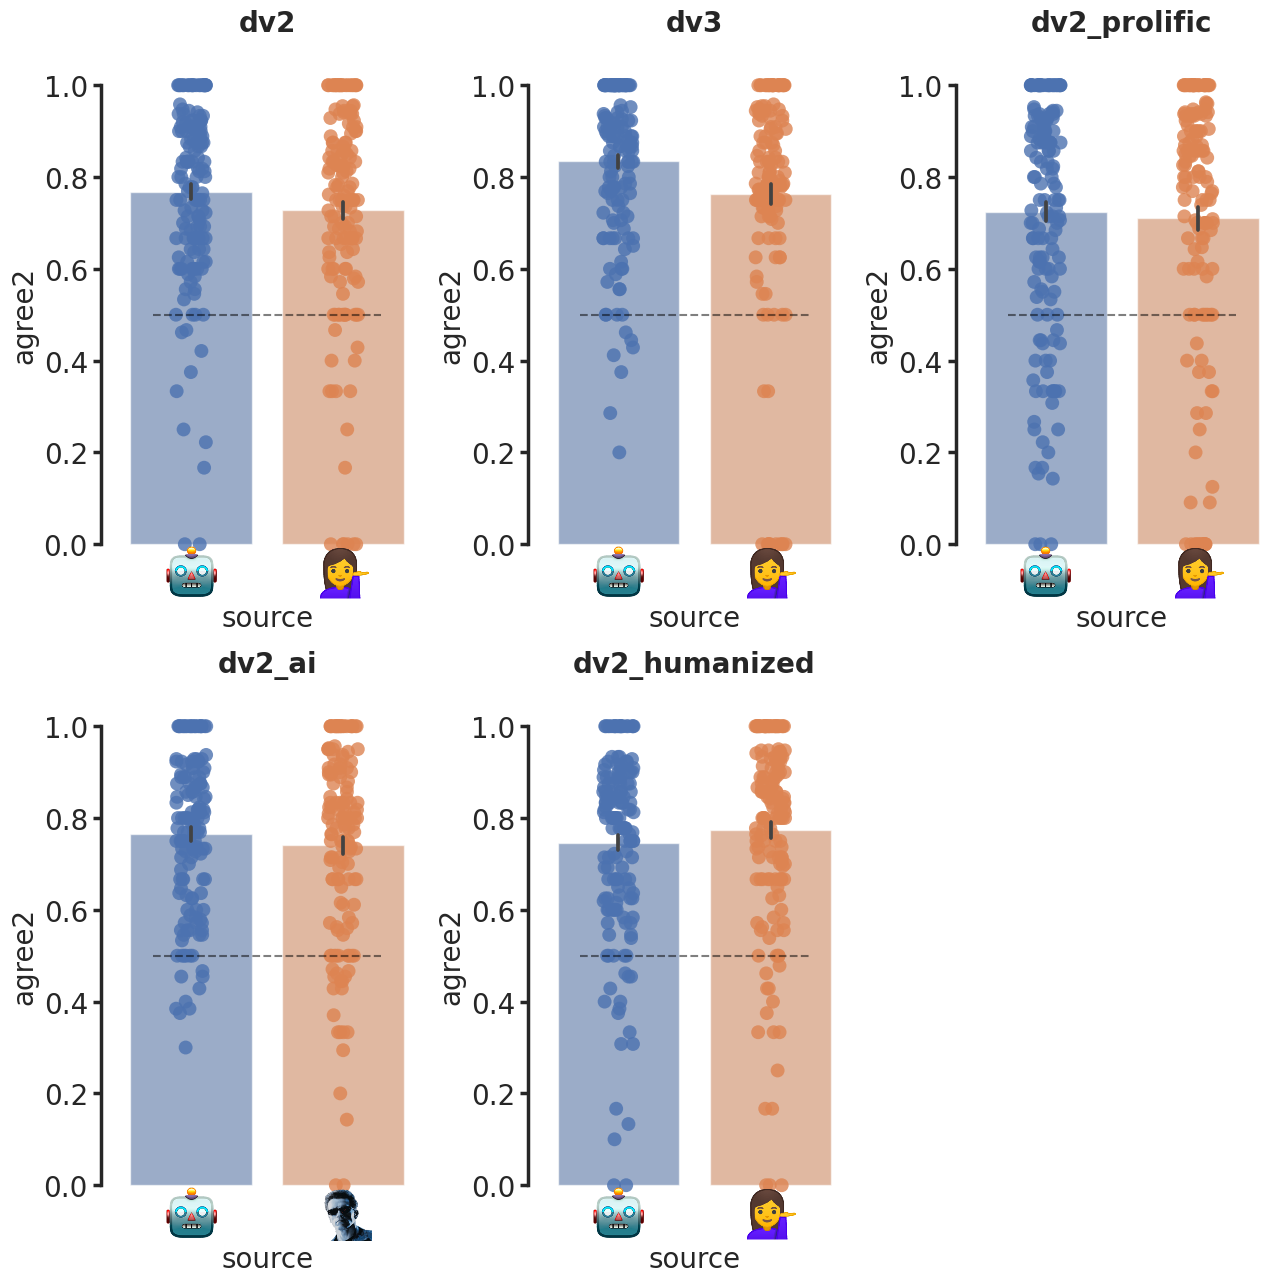

In [111]:
sns.set(
    rc={'figure.figsize':(13,13), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")


count = 0
for engine in ['dv2', 'dv3', 'dv2_prolific', 'dv2_ai', 'dv2_humanized']:
    count += 1
    plt.subplot(2, 3, count)
#
# ids = np.random.choice(df[(df.engine==engine) & (df.q_id == 0) & (df.cond!='non_moral')].prolific_id.unique(), 22, replace=False)
    avg = df[(df.engine==engine) & (df.q_id == 2)].groupby(['prolific_id', 'source', 'correct'], as_index=False).mean()
    print(f'Size of {engine} dataset: ', avg.shape[0]/3)
    # print(avg.answer.unique())
    plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
    sns.barplot(x='source', y='agree2', data=avg, ci=68, alpha=0.6, zorder=0, dodge=True)
    sns.stripplot(x='source', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, zorder=1)
    plt.ylim(-.1, 1.1)
    plt.title('Agreement 1 (Yes/No)')
    plt.xticks(range(2), ('', ''))
    plt.xlabel('')
    plt.xticks([])
    for i, c in enumerate(avg.source.unique()):
        offset_image(i, c, plt.gca(), size=0.3)
    sns.despine(offset=10, trim=True, bottom=True);
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)

    plt.xlabel('source')
    plt.title(engine, fontweight='bold')
    source = avg.source.unique()
    pg.ttest(avg[avg.source==source[0]].agree1, avg[avg.source==source[1]].agree1, paired=True)
plt.tight_layout()
# plt.legend([], [], frameon=False)
print('ANOVA: VAR=agree1, ENGINE=dv2')
#

<AxesSubplot:>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

<AxesSubplot:xlabel='answer', ylabel='agree1'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 1 (Yes/No)')

([<matplotlib.axis.XTick at 0x7f90c4bdca00>,
 [Text(0, 0, ''), Text(1, 0, '')])

([], [])

<AxesSubplot:>

<AxesSubplot:xlabel='answer', ylabel='agree2'>

<AxesSubplot:xlabel='answer', ylabel='agree2'>

(-0.1, 1.1)

Text(0.5, 1.0, 'Agreement 2 (Justification)')

([<matplotlib.axis.XTick at 0x7f90c4b5ae20>,
 [Text(0, 0, ''), Text(1, 0, '')])

([], [])

Text(0.5, 0.98, 'dv2_ai')

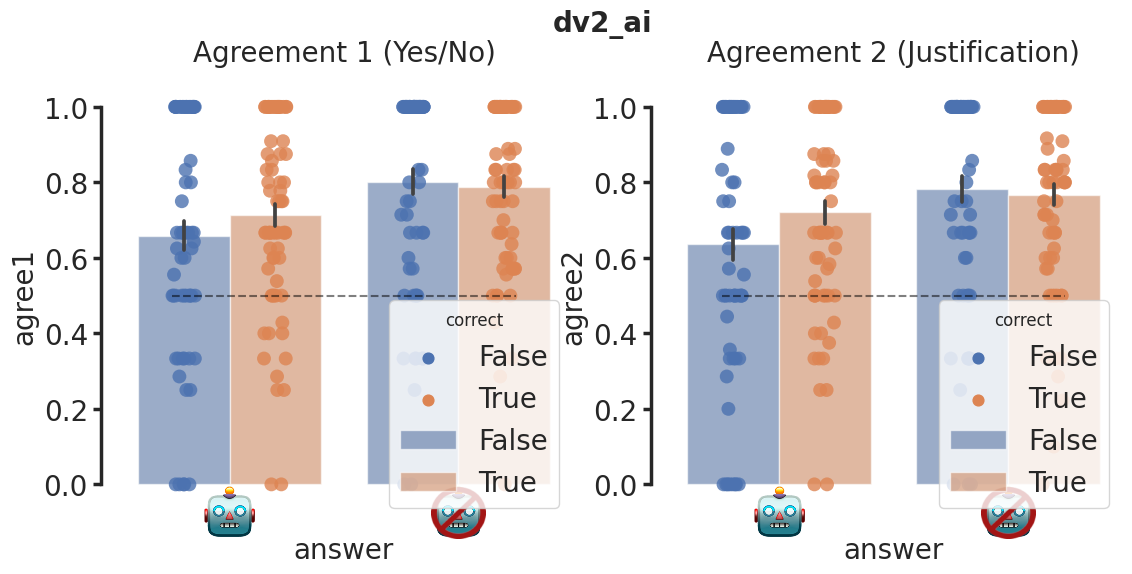

In [17]:
sns.set(
    rc={'figure.figsize':(13,6), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})

# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and answer + anova
# -------------------------------------------------------------------------------


#plt.subplot(1, 3, 1)
#plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
## raincloud(x='answer', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
#sns.barplot(x='answer', y='correct', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0, dodge=True)
#sns.stripplot(x='answer', y='correct', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1)
#plt.ylim(-.1, 1.1)
#plt.title('Correct identification')
#plt.xticks(range(2), ('', ''))
#plt.xlabel('id choice')
#plt.xticks([])
#for i, c in enumerate(avg.answer.unique()):
#    offset_image(i, c, plt.gca(), size=0.3)
#sns.despine(offset=10, trim=True, bottom=True);
#plt.gca().spines['left'].set_linewidth(2.5)
#plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
# print(pg.mixed_anova(data=avg, dv='correct', within='answer', between='correct', subject='prolific_id'))



# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and answer + anova
# -------------------------------------------------------------------------------
engine = 'dv2_ai'
avg = df[(df.engine==engine) & (df.q_id==2) & (df.cond=='personal_moral')].groupby(['prolific_id', 'answer', 'correct'], as_index=False).mean()

plt.subplot(1, 2, 1)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='answer', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='answer', y='agree1', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0, dodge=True)
sns.stripplot(x='answer', y='agree1', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement 1 (Yes/No)')
plt.xticks(range(2), ('', ''))

# plt.xlabel('id choice')
plt.xticks([])
for i, c in enumerate(avg.answer.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
# print(pg.mixed_anova(data=avg, dv='agree1', within='answer', between='correct', subject='prolific_id'))


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and answer + anova
# -------------------------------------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='answer', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='answer', y='agree2', data=avg, ci=68, alpha=0.6, hue='correct', zorder=0)
sns.stripplot(x='answer', y='agree2', data=avg, alpha=0.8, jitter=0.1, size=10, dodge=True, hue='correct', zorder=1, edgecolor='white')
plt.ylim(-.1, 1.1)
plt.title('Agreement 2 (Justification)')
plt.xticks(range(2), ('', ''))
# plt.xlabel('')
plt.xticks([])

# plt.xlabel('id choice')
for i, c in enumerate(avg.answer.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.suptitle(engine, fontweight='bold', fontsize=20)
# plt.legend([], [], frameon=False)
# print(pg.rm_anova(data=avg, dv='agree2', within=['answer', 'correct'], subject='prolific_id', detailed=True))




In [ ]:
df.groupby(['prolific_id', 'source', 'correct'], as_index=False).size()


,prolific_id,source,correct,size
0,542460e3fdf99b691e6ac927,AI,True,51
1,542460e3fdf99b691e6ac927,Human,False,36
2,542460e3fdf99b691e6ac927,Human,True,48
3,5483702ffdf99b24c654b810,AI,False,45
4,5483702ffdf99b24c654b810,AI,True,21
...,...,...,...,...
659,63ea61d8106e3e2dc14c4cc7,Human,True,69
660,63ea627512244090788d46ec,AI,False,12
661,63ea627512244090788d46ec,AI,True,48
662,63ea627512244090788d46ec,Human,False,3


  Source        SS   DF        MS         F     p-unc       ng2       eps
0   cond  0.340806    2  0.170403  7.192593  0.000872  0.024048  0.970557
1  Error  8.055105  340  0.023691       NaN       NaN       NaN       NaN
  Source        SS   DF        MS          F         p-unc     p-GG-corr  \
0   cond  2.099979    2  1.049989  51.383346  3.174503e-20  2.747741e-18   
1  Error  6.947706  340  0.020434        NaN           NaN           NaN   

        ng2       eps sphericity   W-spher   p-spher  
0  0.148092  0.890238      False  0.876705  0.000015  
1       NaN       NaN        NaN       NaN       NaN  


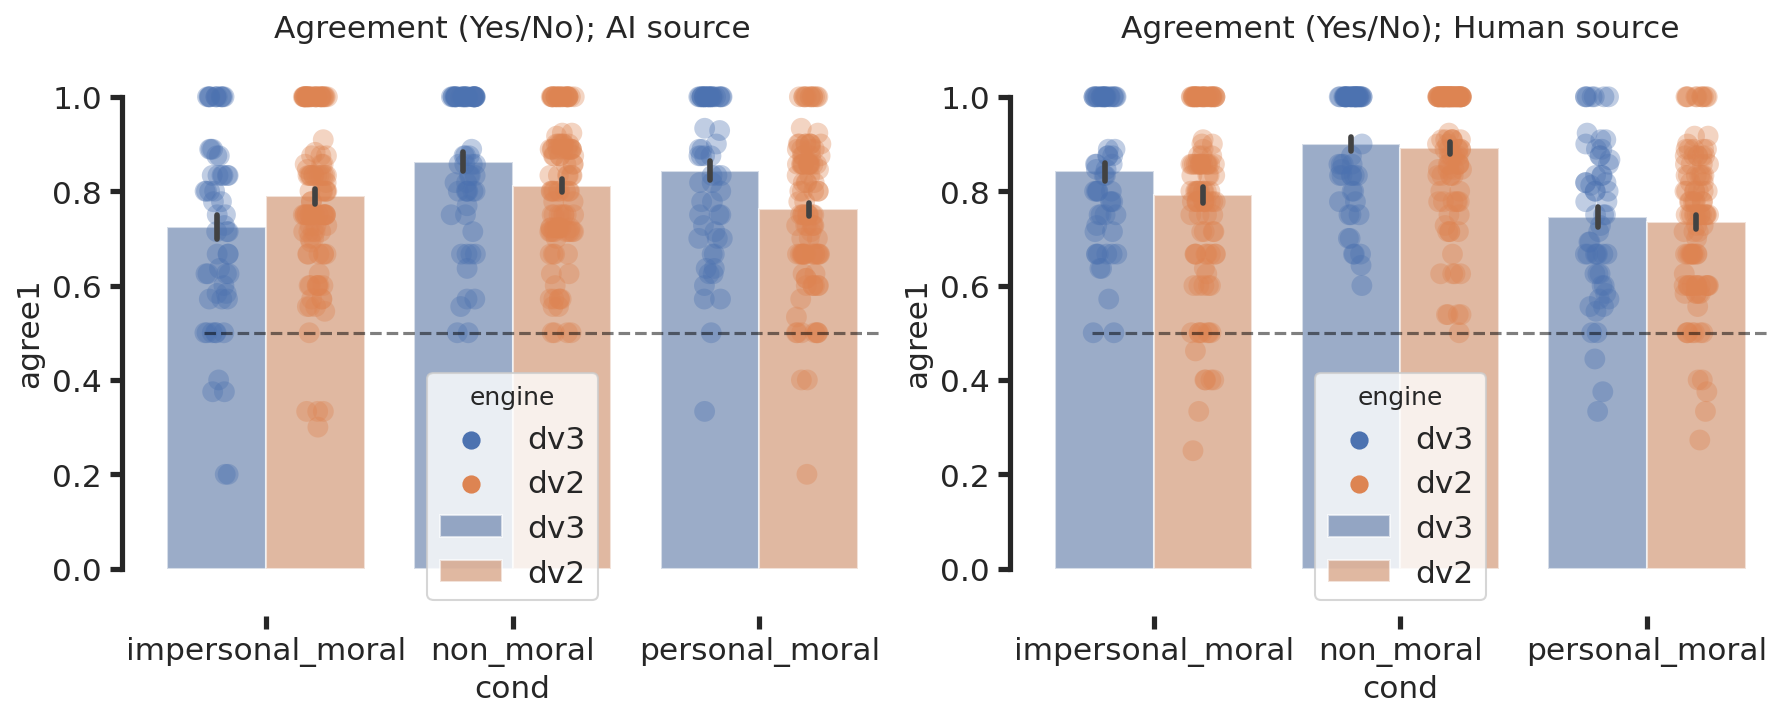

In [ ]:
sns.set(
    rc={'figure.figsize':(14,5), "figure.dpi": 150, 'legend.fontsize': 15, 'axes.labelsize': 15, 'axes.titlesize': 15,
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------

avg = df[df.source=='AI'].groupby(['prolific_id', 'cond', 'engine'], as_index=False).mean()
plt.subplot(1, 2, 1)
# avg = df.groupby(['prolific_id', 'cond', 'agree1'], as_index=False).mean()
plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='cond', y='agree1', hue='engine',data=avg, ci=68, alpha=0.6)
sns.stripplot(x='cond', y='agree1', data=avg, hue='engine', alpha=0.35, jitter=0.1, size=10, dodge=True, zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Yes/No); AI source')
# plt.xticks(range(2), ('', ''))
# plt.xlabel('')
# plt.xticks([])
# for i, c in enumerate(avg.source.unique()):
    # offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree1', within='cond', subject='prolific_id', detailed=True))


#plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
## raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
#sns.barplot(x='cond', y='correct', data=avg, ci=68, alpha=0.6)
#sns.stripplot(x='cond', y='correct', data=avg, alpha=0.35, jitter=0.1, size=10, dodge=True, zorder=1)
#plt.ylim(-.1, 1.1)
#plt.title('Accuracy Turing')
#plt.xticks(range(2), ('', ''))
#plt.xlabel('')
#plt.xticks([])
## for i, c in enumerate(avg.source.unique()):
#    # offset_image(i, c, plt.gca(), size=0.3)
#sns.despine(offset=10, trim=True, bottom=True);
#plt.gca().spines['left'].set_linewidth(2.5)
#plt.gca().spines['bottom'].set_linewidth(2.5)
#plt.legend([], [], frameon=False)
#print(pg.rm_anova(data=avg, dv='correct', within='cond', subject='prolific_id', detailed=True))


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# -------------------------------------------------------------------------------
#
avg = df[df.source=='Human'].groupby(['prolific_id', 'cond', 'engine'], as_index=False).mean()
plt.subplot(1, 2, 2)
# avg = df.groupby(['prolific_id', 'cond', 'agree1'], as_index=False).mean()
plt.plot([-0.25, 3.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='cond', y='agree1', hue='engine',data=avg, ci=68, alpha=0.6)
sns.stripplot(x='cond', y='agree1', data=avg, hue='engine', alpha=0.35, jitter=0.1, size=10, dodge=True, zorder=1)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Yes/No); Human source')
# plt.xticks(range(2), ('', ''))
# plt.xlabel('')
# plt.xticks([])
# for i, c in enumerate(avg.source.unique()):
    # offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
# plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree1', within='cond', subject='prolific_id', detailed=True))
